In [2]:
from legend_plot_style import LEGENDPlotStyle as lps
lps.use("legend_talks")
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import math
from collections import Counter
from scipy.interpolate import interp1d

file_path = '/home/eric/sim/WWLegend/Archive/Neutrontaggerruns/'
""" Amount is required to know how many entries belong to each neutron. 
    nPMMA is an array where each entry says how many photon timestamp belong to that neutron.
    Time for the time entries. Each entry is one photon timestamp.
    no is required to match Shower IDs, Identifier for something else.
    Read in 2 different setups to compare!"""
nPMMA = np.loadtxt(file_path + "Warwick with ArgonModerator/Scintillator/ScintWithPMTQE10cmAmount.csv", dtype=float, delimiter=',', skiprows=5, unpack=True) #first name
timePMMA,WavelengthsPMMA = np.loadtxt(file_path + "Warwick with ArgonModerator/Scintillator/ScintWithPMTQE10cmTimes.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

nPMMAFoil = np.loadtxt(file_path + "Warwick with ArgonModerator/Baseline/BaselineWithPMTQEAmount.csv", dtype=float, delimiter=',', skiprows=5, unpack=True) #second name
timePMMAFoil, WavelengthsPMMAFoil = np.loadtxt(file_path + "Warwick with ArgonModerator/Baseline/BaselineWithPMTQETimes.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

""" no carries the id to which shower each neutron belongs. """
no, x, y, z, ekin, NeutronCaptureTimeDelay = np.loadtxt(file_path + "Warwick with ArgonModerator/ShowerIDs2.txt", dtype=float, delimiter=',', unpack=True) #first name
identifierPMMA, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick with ArgonModerator/PMMARun2.txt", dtype=float, delimiter=',', unpack=True)

no2, x2, y2, z2, ekin2, NeutronCaptureTimeDelay2 = np.loadtxt(file_path + "Warwick with ArgonModerator/ShowerIDs2.txt", dtype=float, delimiter=',', unpack=True) 
identifierPMMA2, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick with ArgonModerator/PMMARun2.txt", dtype=float, delimiter=',', unpack=True) #second name

name1= "Scintillator"  # belongs to "first" read in setup
name2 = "Baseline" # belongs to "second" read in setup

Plot 2d Histogram with Real Captures in water on the x-Axis and Measure captures or integral light on the y-Axis

In [14]:
def subarray_it_up(n, time, id):
    """ Takes array of number of timestamps per neutron, the timestamps 
        and the array of ids of the corresponding Shower of the neutron. 
        Returns Array where each subarray corresponds to all 
        Timestamps of one Shower. Size should be amount of Showers."""
    unique, counts = np.unique(id, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts.astype(int)
    cum_n = np.cumsum(n)
    cum_n = cum_n.astype(int)
    subarrays = [time[0 if i == 0 else cum_n[(cum_counts[i-1]) - 1]:cum_n[(cum_counts[i])-1]] for i in range(len(counts))]
    return subarrays

def histlist(AllShowers, window, timeMax):
    """ Takes whole Shower array and divides each Shower 
        in time windows of size "window" up to timeMax.
        Returns Array with histogram for each Shower
        with window/timeMax bins and max range timeMax."""
    b = int(timeMax/window)
    hists_list = []
    for Shower in AllShowers:
        x, y = np.histogram(Shower, bins=b, range=(0, timeMax))
        hists_list.append(x)
    hists_array = np.array(hists_list)
    return hists_array

def mult_to_phot(mult, Npmt):
    """ Uses surface of Hit area and single PMT area (hardcoded).
        Takes the given multiplicity of PMTs + deployed amount of PMTs.
        Returns how many photon hits are required to fullfill multiplicity
        assuming isotropic hit location. ADJUSTED TO ASSUME PMT QE WAS ALREADY APPLIED"""
    F = 467
    Fpmt = 0.05
    return (mult * F /( Npmt * Fpmt))

def bins_over_thresh(arr, threshold):
    """ Takes single array and a threshold.
        Returns how many entries are above threshold"""
    res = np.sum(arr > threshold)
    return res

def distinguished_neutrons(AllShowers, mult, Npmt, window, timeMax):
    """ Takes whole Shower array, a given multiplicity, 
        given Amount of PMTs, size of coincidence intervall
        (in ns) and maximum time delay (in ns).
        Returns an array where each entry is the amount of neutrons
        of that Shower that would be detected with these 4 conditions.
    """
    hists_array = histlist(AllShowers, window,timeMax)
    threshold = mult_to_phot(mult, Npmt)
    results_array = np.array([])
    for i in hists_array:
        results_array = np.append(results_array, bins_over_thresh(i, threshold))
    return results_array

def Photons_in_intervall_and_200ns(n,times,startTime,endTime):
    """ Takes the array of photons per Ncapture and counts only those within the time intervall + only those that are within 200ns of the first.
    Returns array of photons within intervall per Ncapture. """
    cum_index = np.cumsum(n)
    cum_index = cum_index.astype(int)
    # Insert 0 as the first starting index
    start_indexes = np.insert(cum_index[:-1], 0, 0)
    end_indexes = cum_index

    # Initialize an array to store the counts
    counts = np.zeros(len(start_indexes), dtype=int)

    for i, (start, end) in enumerate(zip(start_indexes, end_indexes)):
        # Get the times within the interval
        times_within_interval = times[start:end]
        if len(times_within_interval) > 0:
            first = np.min(times_within_interval)
            # Count the values in the time interval
            counts[i] = np.sum(((times_within_interval > startTime) & (times_within_interval < endTime)) & (times_within_interval < (first + 200)))
    return counts

subPMMAFoil = subarray_it_up(nPMMAFoil, timePMMAFoil, no)

unique, counts = np.unique(no2, return_counts=True) #Counts should have the number of captures for Each shower.
#Now filter out all the water captures
cum_counts = np.cumsum(counts)
cum_counts = cum_counts.astype(int)
counts_only_water = [np.sum(identifierPMMA2[0 if i == 0 else cum_counts[i-1]:cum_counts[i]] != 4) for i in range(len(counts))]



neutrons = distinguished_neutrons(AllShowers=subPMMAFoil,mult=6, Npmt=500, window=200, timeMax=200000)
Photons_inTime200Setup2 = Photons_in_intervall_and_200ns(nPMMAFoil, timePMMAFoil, 10000, 200000)

# Check if the sum of counts matches the length of the second array
if counts.sum() != len(Photons_inTime200Setup2):
    raise ValueError("The sum of 'counts' must be equal to the length of 'second_array'.")

# Initialize the new array to store the sums
Photons_inTimeConcenuated = np.empty_like(counts)

# Index to keep track of position in the second array
index = 0

# Populate the new array
for i, count in enumerate(counts):
    Photons_inTimeConcenuated[i] = Photons_inTime200Setup2[index:index + count].sum()
    index += count

print(counts_only_water)
print(np.size(neutrons))
print(np.size(Photons_inTimeConcenuated))

[3, 4, 0, 1, 34, 46, 1, 286, 34, 0, 0, 626, 0, 1441, 52, 740, 0, 66, 4, 66, 12, 88, 91, 0, 2, 89, 2221, 0, 54, 25, 35, 7, 2, 1, 4, 5, 5, 176, 293, 2, 0, 3, 15, 24, 14, 59, 0, 659, 7, 98, 532, 28, 1366, 21, 0, 42, 54, 50, 55, 23, 4, 15, 14, 34, 17, 24, 2, 678, 0, 0, 0, 81, 209, 688, 160, 1, 293, 7, 19, 607, 44, 90, 21, 3, 18, 0, 0, 58, 126, 2, 0, 174, 92, 0, 0, 500, 15, 278, 113, 2, 2, 1638, 313, 0, 227, 8, 35, 46, 1, 35, 16, 82, 384, 28, 0, 139, 12, 2, 46, 0, 0, 8, 7, 2, 1, 0, 3, 279, 22, 272, 1, 39, 6, 57, 0, 10, 4, 202, 64, 120, 3, 8, 236, 0, 237, 2, 638, 4, 15, 2, 21, 221, 33, 3, 543, 23, 0, 60, 1459, 48, 0, 16, 124, 4, 189, 78, 0, 66, 832, 19, 118, 13, 21, 13, 0, 711, 115, 2, 0, 613, 0, 0, 1918, 1287, 197, 1, 7, 3, 106, 12, 0, 2, 7, 1462, 12, 374, 0, 128, 38, 10, 19, 0, 1901, 46, 0, 238, 96, 533, 1428]
209
209


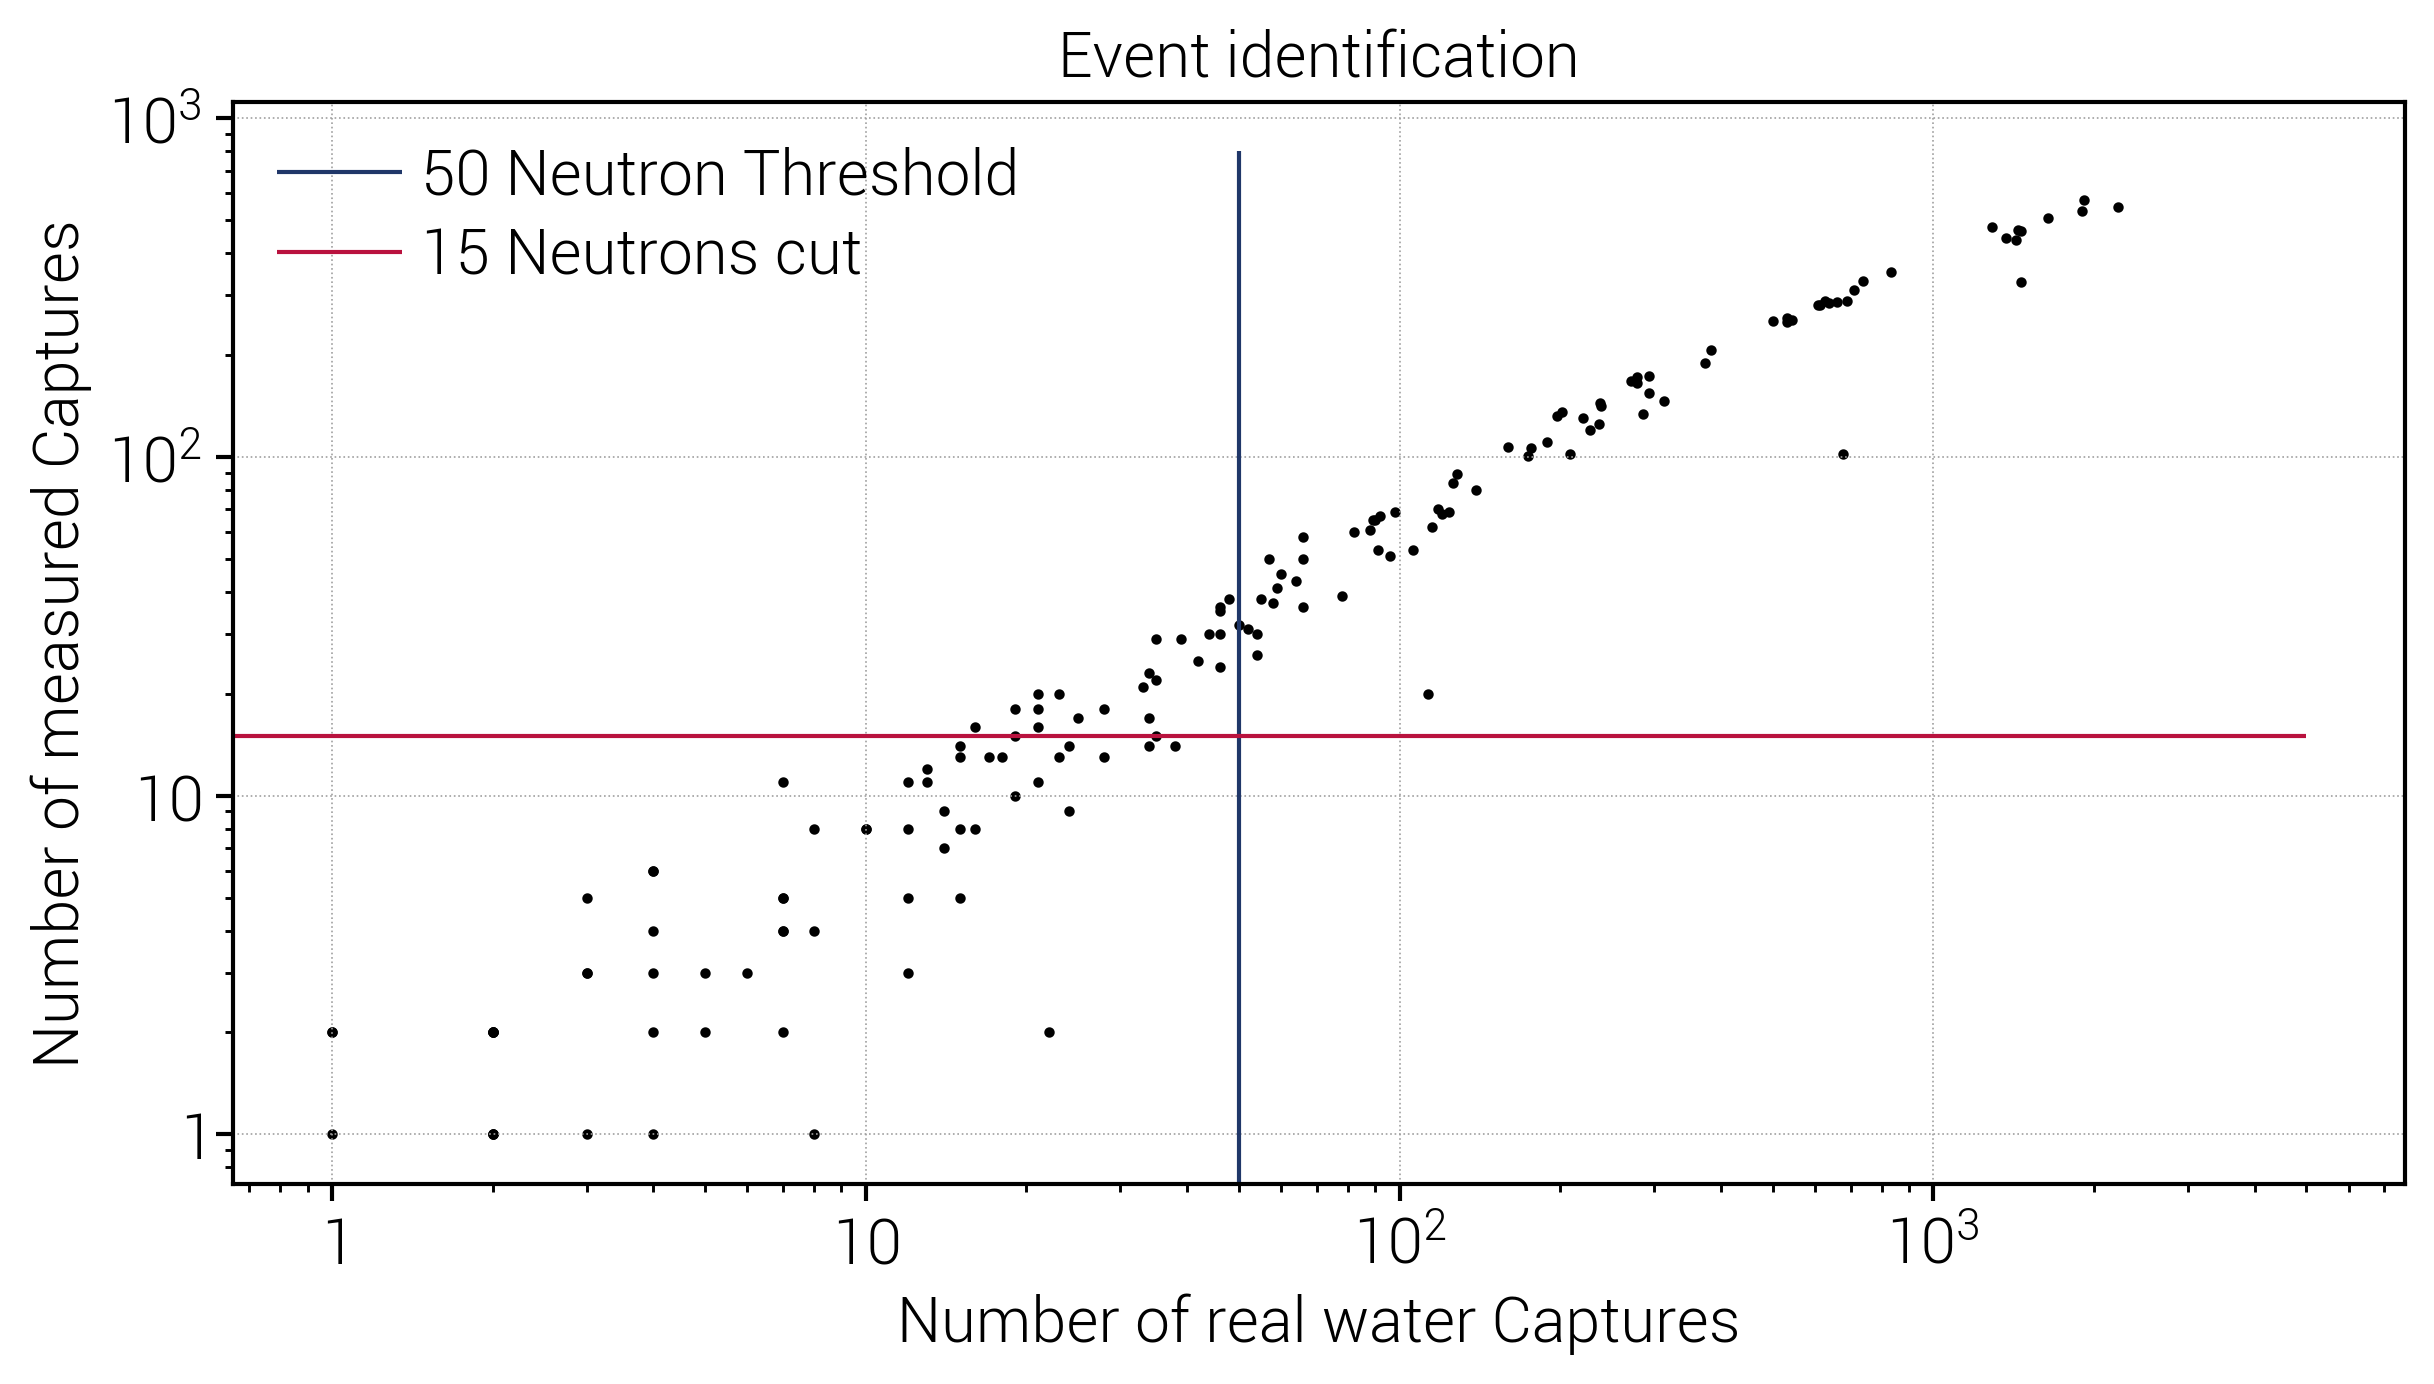

In [24]:
n_bins = 100
plt.scatter(counts_only_water, neutrons)

plt.xlabel('Number of real water Captures')
plt.ylabel('Number of measured Captures')
plt.title('Event identification')
plt.xscale("log")
plt.yscale("log")
plt.vlines(x=50, ymin=0, ymax=800, color = lps.colors["darkblue"], label="50 Neutron Threshold")
plt.hlines(y=15, xmin=0, xmax=5000, color = lps.colors["red"], label="15 Neutrons cut")
plt.grid()
plt.legend(loc= "upper left")

#plt.savefig("/home/eric/sim/WWLegend/Plots/EventIdentification/MeasuredNeutrons.png")
plt.show()

Now do same but on y axis integral light

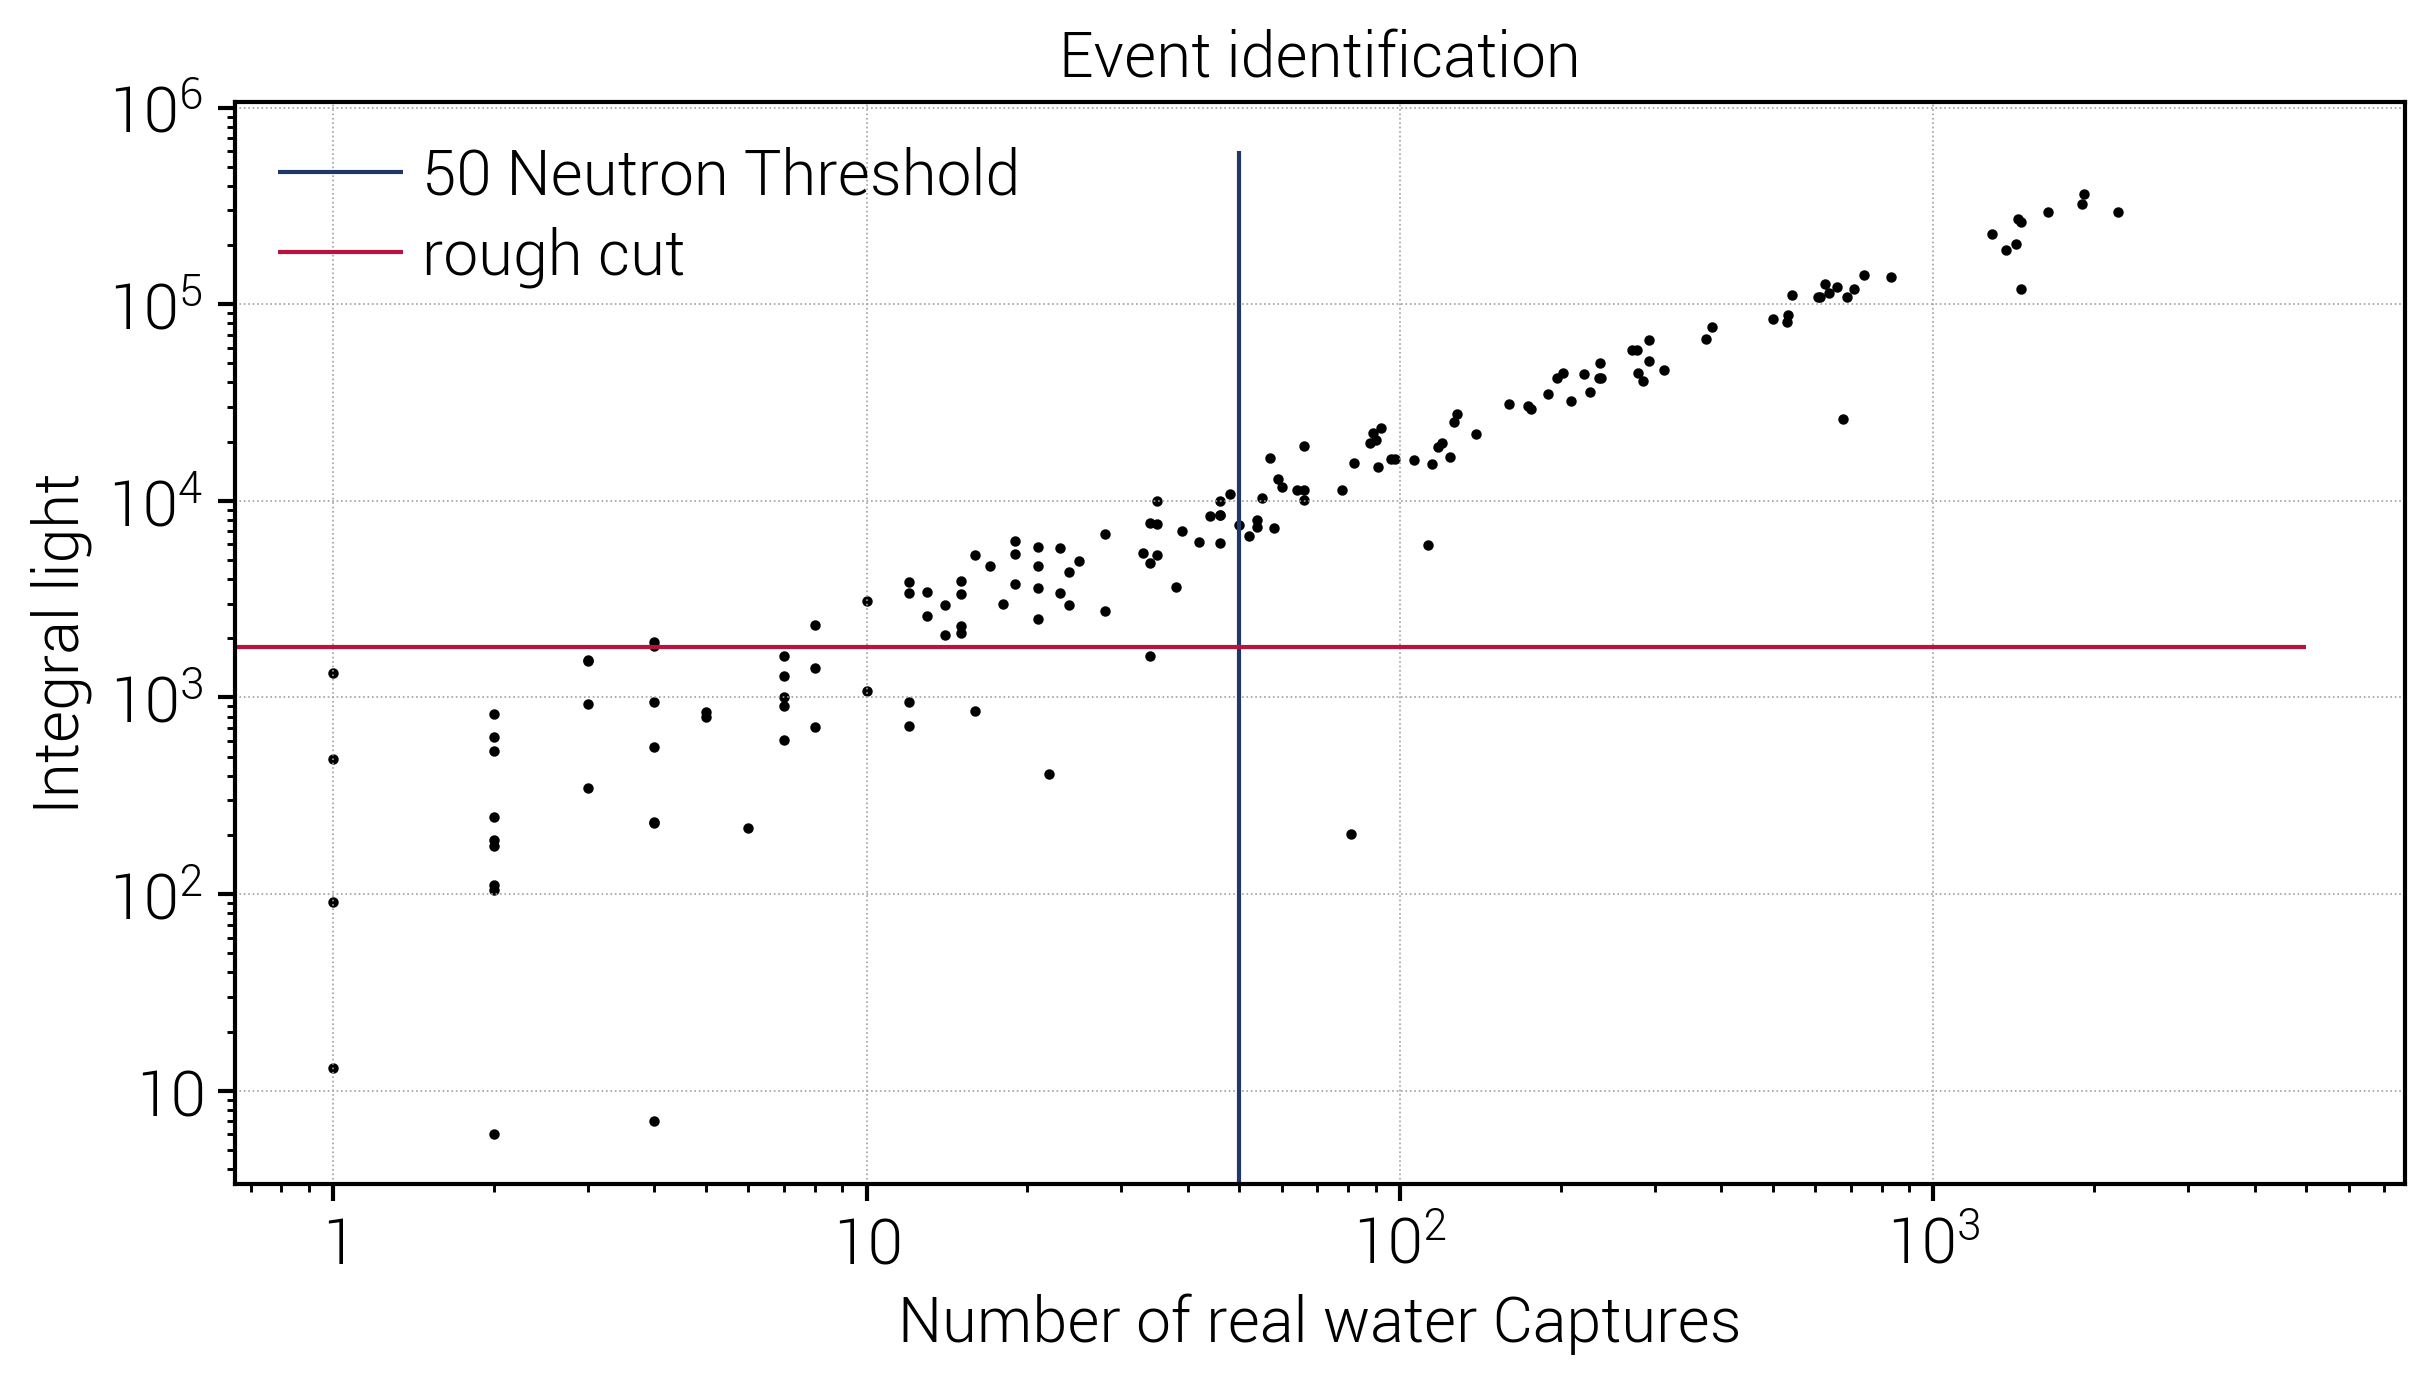

In [25]:
n_bins = 100
plt.scatter(counts_only_water, Photons_inTimeConcenuated)

plt.xlabel('Number of real water Captures')
plt.ylabel('Integral light')
plt.title('Event identification')
plt.xscale("log")
plt.yscale("log")
plt.vlines(x=50, ymin=0, ymax=6e5, color = lps.colors["darkblue"], label="50 Neutron Threshold")
plt.hlines(y=120*15, xmin=0, xmax=5000, color = lps.colors["red"], label="rough cut")
plt.grid()
plt.legend(loc= "upper left")

#
#plt.savefig("/home/eric/sim/WWLegend/Plots/EventIdentification/IntegralLight.png")
plt.show()